# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [21]:
#!pip install opencv-python

In [22]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential,Model


In [1]:
import numpy as np
import os
import scipy
#from scipy.misc import imresize
# from PIL.Image import  as imresize
from matplotlib.pyplot import imread
import cv2
from skimage.transform import resize
from scipy import misc 
import datetime
import os
import matplotlib.pyplot as plt

import abc
from sys import getsizeof
import warnings
warnings.filterwarnings(action='ignore')

C:\Users\Abhinav94\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation,Dropout,LSTM
from keras.layers.convolutional import Conv3D,Conv2D,MaxPooling2D,MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:

batch_size = 600 #experiment with the batch size

In [5]:
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
project_folder = "Project_data"

In [7]:
class ModelBuilder(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized = resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized= resize(cropped,(self.image_height,self.image_width,3))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model/model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = 'model/'+model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, 
                                     mode='auto',period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

# Base Model

In [30]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [31]:
con3d1 = ModelConv3D1()
con3d1.initialize_path(project_folder)
con3d1.initialize_image_properties(image_height=160,image_width=160)
con3d1.initialize_hyperparams(frames_to_sample=30,batch_size=40,num_epochs=1)
con3d1_model = con3d1.define_model()
con3d1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_9 (Activation)   (None, 15, 80, 80, 32)   

In [32]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109538912773 Gigs


In [33]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=3)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/3
23/23 [==============================] - ETA: 0s - loss: 1.5651 - categorical_accuracy: 0.4389 
Epoch 1: saving model to model/model/model_init_2023-09-0213_26_36.458013\model-00001-1.56513-0.43891-2.32540-0.22000.h5
23/23 [==============================] - 528s 23s/step - loss: 1.5651 - categorical_accuracy: 0.4389 - val_loss: 2.3254 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/3
23/23 [==============================] - ETA: 0s - loss: 0.9691 - categorical_accuracy: 0.6350 
Epoch 2: saving model to model/model/model_init_2023-09-0213_26_36.458013\model-00002-0.96909-0.63499-4.87986-0.21000.h5
23/23 [==============================] - 282s 12s/step - loss: 0.9691 - categorical_accuracy: 0.6350 - val_loss: 4.8799 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/3
23/23 [==============================] - ETA: 0s - loss: 0.7191 - categorical_accuracy: 0.7406 
Epoch 3: saving model to model/model/model_init_2023-09-0213_26_36.458013\model-00

In [34]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.6336 - categorical_accuracy: 0.4027 
Epoch 1: saving model to model/model/model_init_2023-09-0213_44_58.880519\model-00001-1.63360-0.40271-10.63034-0.16000.h5
45/45 [==============================] - 531s 12s/step - loss: 1.6336 - categorical_accuracy: 0.4027 - val_loss: 10.6303 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.0983 - categorical_accuracy: 0.5581 
Epoch 2: saving model to model/model/model_init_2023-09-0213_44_58.880519\model-00002-1.09831-0.55807-19.11258-0.15000.h5
45/45 [==============================] - 525s 12s/step - loss: 1.0983 - categorical_accuracy: 0.5581 - val_loss: 19.1126 - val_categorical_accuracy: 0.1500 - lr: 0.0010


In [35]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
23/23 [==============================] - ETA: 0s - loss: 1.6564 - categorical_accuracy: 0.4148
Epoch 1: saving model to model/model/model_init_2023-09-0214_02_38.423808\model-00001-1.65640-0.41478-3.05869-0.16000.h5
23/23 [==============================] - 213s 9s/step - loss: 1.6564 - categorical_accuracy: 0.4148 - val_loss: 3.0587 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
23/23 [==============================] - ETA: 0s - loss: 1.1175 - categorical_accuracy: 0.5671
Epoch 2: saving model to model/model/model_init_2023-09-0214_02_38.423808\model-00002-1.11750-0.56712-5.51694-0.16000.h5
23/23 [==============================] - 214s 9s/step - loss: 1.1175 - categorical_accuracy: 0.5671 - val_loss: 5.5169 - val_categorical_accuracy: 0.1600 - lr: 0.0010


In [36]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=15,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
45/45 [==============================] - ETA: 0s - loss: 1.7368 - categorical_accuracy: 0.4087
Epoch 1: saving model to model/model/model_init_2023-09-0214_09_48.423476\model-00001-1.73684-0.40875-3.85513-0.18000.h5
45/45 [==============================] - 216s 5s/step - loss: 1.7368 - categorical_accuracy: 0.4087 - val_loss: 3.8551 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/2
45/45 [==============================] - ETA: 0s - loss: 1.2369 - categorical_accuracy: 0.5309
Epoch 2: saving model to model/model/model_init_2023-09-0214_09_48.423476\model-00002-1.23685-0.53092-7.28879-0.14000.h5
45/45 [==============================] - 216s 5s/step - loss: 1.2369 - categorical_accuracy: 0.5309 - val_loss: 7.2888 - val_categorical_accuracy: 0.1400 - lr: 0.0010


In [37]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.6089 - categorical_accuracy: 0.4012
Epoch 1: saving model to model/model/model_init_2023-09-0214_17_02.627989\model-00001-1.60891-0.40121-7.89648-0.23000.h5
67/67 [==============================] - 539s 8s/step - loss: 1.6089 - categorical_accuracy: 0.4012 - val_loss: 7.8965 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.2436 - categorical_accuracy: 0.5008
Epoch 2: saving model to model/model/model_init_2023-09-0214_17_02.627989\model-00002-1.24360-0.50075-12.99899-0.24000.h5
67/67 [==============================] - 531s 8s/step - loss: 1.2436 - categorical_accuracy: 0.5008 - val_loss: 12.9990 - val_categorical_accuracy: 0.2400 - lr: 0.0010


In [38]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=10,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
67/67 [==============================] - ETA: 0s - loss: 1.8008 - categorical_accuracy: 0.3409
Epoch 1: saving model to model/model/model_init_2023-09-0214_34_54.468609\model-00001-1.80078-0.34087-13.29196-0.21000.h5
67/67 [==============================] - 286s 4s/step - loss: 1.8008 - categorical_accuracy: 0.3409 - val_loss: 13.2920 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
67/67 [==============================] - ETA: 0s - loss: 1.2920 - categorical_accuracy: 0.4992
Epoch 2: saving model to model/model/model_init_2023-09-0214_34_54.468609\model-00002-1.29197-0.49925-18.53258-0.22000.h5
67/67 [==============================] - 286s 4s/step - loss: 1.2920 - categorical_accuracy: 0.4992 - val_loss: 18.5326 - val_categorical_accuracy: 0.2200 - lr: 0.0010


In [39]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=40,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
17/17 [==============================] - ETA: 0s - loss: 1.5812 - categorical_accuracy: 0.3952 
Epoch 1: saving model to model/model/model_init_2023-09-0214_44_27.704500\model-00001-1.58125-0.39517-2.70185-0.16000.h5
17/17 [==============================] - 278s 16s/step - loss: 1.5812 - categorical_accuracy: 0.3952 - val_loss: 2.7019 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 0.9995 - categorical_accuracy: 0.5958 
Epoch 2: saving model to model/model/model_init_2023-09-0214_44_27.704500\model-00002-0.99945-0.59578-4.53033-0.19000.h5
17/17 [==============================] - 272s 16s/step - loss: 0.9995 - categorical_accuracy: 0.5958 - val_loss: 4.5303 - val_categorical_accuracy: 0.1900 - lr: 0.0010


As we see from the above experiments image resolution and number of frames in sequence have more impact on training time than batch_size
So experimentations are carried with batch size fixed around 15-40 and changing the resolution and number of image per sequence based on the device memory constraints . Models are designed such that their memory foot print is less than 50 MB which corresponds to 4.3 million parameters assuming the datatype size of parameters to be 12 bytes

# Model 1 - Base Model - No Data Augmentation Batch Size 40 and Epoch 15

In [40]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [41]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_40 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_40 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_60 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_40 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_41 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_41 (Activation)  (None, 10, 80, 80, 32)  

In [42]:
print("Total Params: ",conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params:  1117061
Epoch 1/15
17/17 [==============================] - ETA: 0s - loss: 1.7907 - categorical_accuracy: 0.3424 
Epoch 1: saving model to model/model/model_init_2023-09-0214_53_42.333225\model-00001-1.79071-0.34238-3.60865-0.22000.h5
17/17 [==============================] - 432s 25s/step - loss: 1.7907 - categorical_accuracy: 0.3424 - val_loss: 3.6086 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/15
17/17 [==============================] - ETA: 0s - loss: 1.1165 - categorical_accuracy: 0.5596 
Epoch 2: saving model to model/model/model_init_2023-09-0214_53_42.333225\model-00002-1.11647-0.55958-7.43375-0.26000.h5
17/17 [==============================] - 422s 25s/step - loss: 1.1165 - categorical_accuracy: 0.5596 - val_loss: 7.4338 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/15
17/17 [==============================] - ETA: 0s - loss: 0.9136 - categorical_accuracy: 0.6440 
Epoch 3: saving model to model/model/model_init_2023-09-0214_53_42.333225\mode

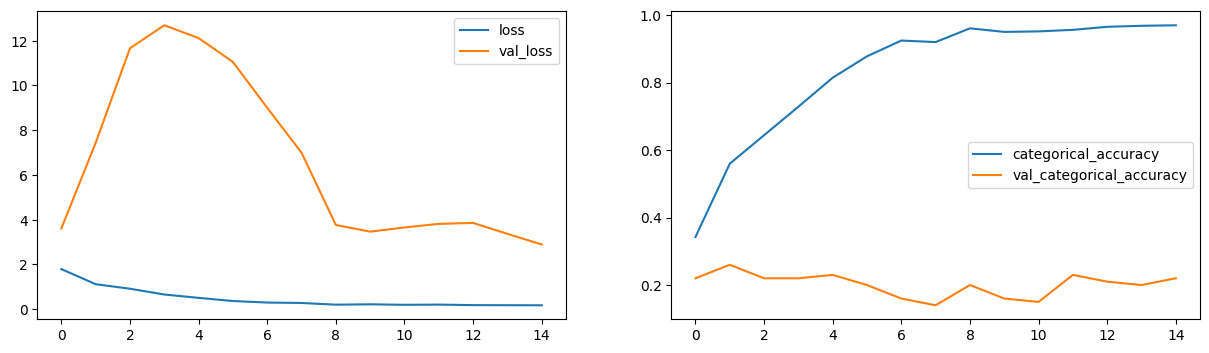

In [43]:
plot(history_model1)

Model is clearly overfitting as validation accuracy is way too low . So we need to do data augmentation

# Model 2 - Augment Data , (3,3,3) filter & 160x160 image resolution

In [44]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_44 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_44 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_66 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_44 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_45 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_45 (Activation)  (None, 10, 80, 80, 32)  

In [45]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.9760 - categorical_accuracy: 0.3952 
Epoch 1: saving model to model/model/model_init_2023-09-0216_42_03.403742\model-00001-1.97600-0.39517-3.54363-0.16000.h5
34/34 [==============================] - 874s 26s/step - loss: 1.9760 - categorical_accuracy: 0.3952 - val_loss: 3.5436 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6070 - categorical_accuracy: 0.4781 
Epoch 2: saving model to model/model/model_init_2023-09-0216_42_03.403742\model-00002-1.60704-0.47813-6.61598-0.21000.h5
34/34 [==============================] - 851s 25s/step - loss: 1.6070 - categorical_accuracy: 0.4781 - val_loss: 6.6160 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.2521 - categorical_accuracy: 0.5618 
Epoch 3: saving model to model/model/model_init_2023-09-0216_42_03.403742\model

34/34 [==============================] - 819s 24s/step - loss: 0.7504 - categorical_accuracy: 0.7195 - val_loss: 3.0096 - val_categorical_accuracy: 0.3200 - lr: 1.6000e-06
Epoch 21/25
34/34 [==============================] - ETA: 0s - loss: 0.6941 - categorical_accuracy: 0.7383 
Epoch 21: saving model to model/model/model_init_2023-09-0216_42_03.403742\model-00021-0.69413-0.73831-2.29627-0.37000.h5
34/34 [==============================] - 816s 24s/step - loss: 0.6941 - categorical_accuracy: 0.7383 - val_loss: 2.2963 - val_categorical_accuracy: 0.3700 - lr: 1.6000e-06
Epoch 22/25
34/34 [==============================] - ETA: 0s - loss: 0.7510 - categorical_accuracy: 0.7360 
Epoch 22: saving model to model/model/model_init_2023-09-0216_42_03.403742\model-00022-0.75097-0.73605-1.71380-0.52000.h5
34/34 [==============================] - 813s 24s/step - loss: 0.7510 - categorical_accuracy: 0.7360 - val_loss: 1.7138 - val_categorical_accuracy: 0.5200 - lr: 1.6000e-06
Epoch 23/25
34/34 [=====

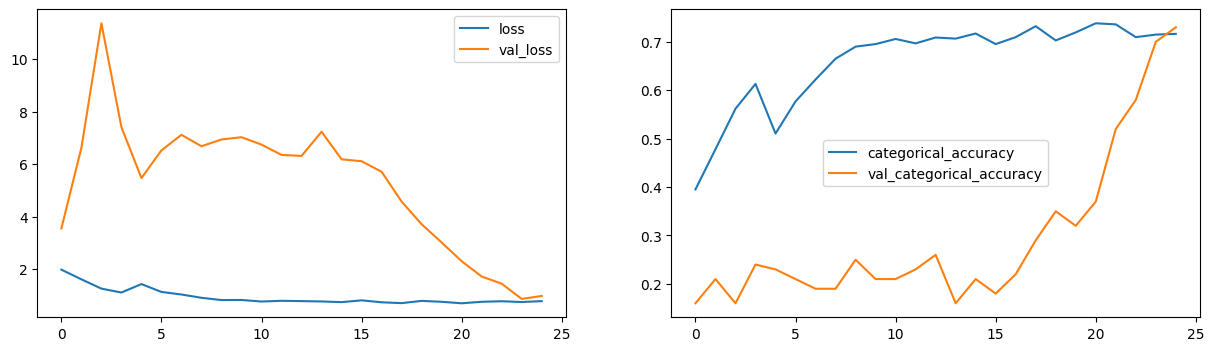

In [46]:
plot(history_model2)

Model is not overfitting and we get a best validation accuracy of 73% and training accuracy of around 74%. Next we will try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations in loss, let's try lowering the learning rate to 0.0002

# Model 3 - Reduce filter size to (2,2,2) and image res to 120 x 120

In [47]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [48]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_48 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_72 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_48 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_49 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_49 (Activation)  (None, 8, 60, 60, 32)   

In [49]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.1956 - categorical_accuracy: 0.3296 
Epoch 1: saving model to model/model/model_init_2023-09-0222_27_39.443629\model-00001-2.19557-0.32956-1.81494-0.21000.h5
23/23 [==============================] - 274s 12s/step - loss: 2.1956 - categorical_accuracy: 0.3296 - val_loss: 1.8149 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.4717 - categorical_accuracy: 0.4819 
Epoch 2: saving model to model/model/model_init_2023-09-0222_27_39.443629\model-00002-1.47172-0.48190-2.37198-0.21000.h5
23/23 [==============================] - 266s 12s/step - loss: 1.4717 - categorical_accuracy: 0.4819 - val_loss: 2.3720 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.2796 - categorical_accuracy: 0.5732 
Epoch 3: saving model to model/model/model_init_2023-09-0222_27_39.4436

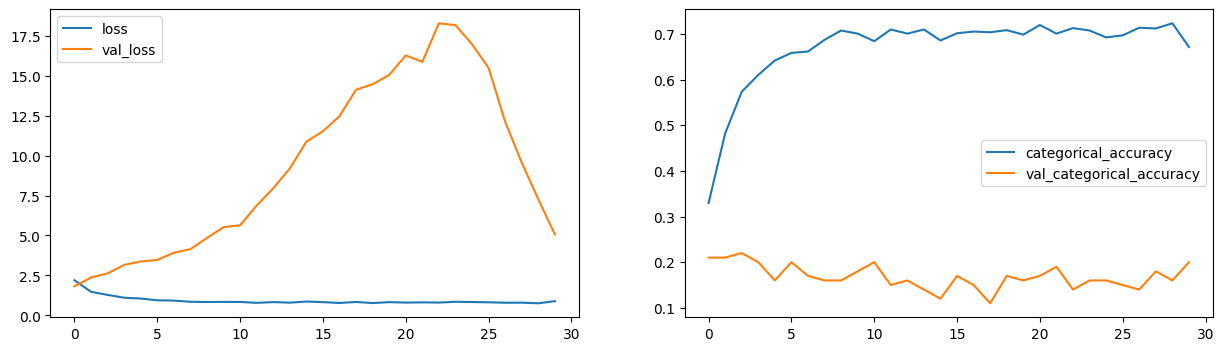

In [50]:
plot(history_model3)

Model has a best validation accuracy of 20% and training accuracy of around 74% . Model is clearly overfit 

Let's trying adding more layers

# Model 4 - Adding more layers

In [51]:
class ModelConv3D4(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [52]:
conv_3d4=ModelConv3D4()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=120,image_width=120)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d4_model=conv_3d4.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_52 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_52 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_78 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_53 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_53 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_79 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                    

In [53]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9728 - categorical_accuracy: 0.3688 
Epoch 1: saving model to model/model/model_init_2023-09-0300_40_16.581830\model-00001-1.97281-0.36878-3.58530-0.21000.h5
34/34 [==============================] - 970s 28s/step - loss: 1.9728 - categorical_accuracy: 0.3688 - val_loss: 3.5853 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4313 - categorical_accuracy: 0.4827 
Epoch 2: saving model to model/model/model_init_2023-09-0300_40_16.581830\model-00002-1.43134-0.48265-6.04750-0.20000.h5
34/34 [==============================] - 969s 28s/step - loss: 1.4313 - categorical_accuracy: 0.4827 - val_loss: 6.0475 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3543 - categorical_accuracy: 0.5324 
Epoch 3: saving model to model/model/model_init_2023-09-0300_40_16.581830\model

34/34 [==============================] - 972s 29s/step - loss: 0.4763 - categorical_accuracy: 0.8288 - val_loss: 3.4640 - val_categorical_accuracy: 0.2500 - lr: 1.6000e-06
Epoch 21/30
34/34 [==============================] - ETA: 0s - loss: 0.4840 - categorical_accuracy: 0.8137 
Epoch 21: saving model to model/model/model_init_2023-09-0300_40_16.581830\model-00021-0.48405-0.81373-2.54377-0.33000.h5
34/34 [==============================] - 973s 29s/step - loss: 0.4840 - categorical_accuracy: 0.8137 - val_loss: 2.5438 - val_categorical_accuracy: 0.3300 - lr: 1.6000e-06
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.4729 - categorical_accuracy: 0.8175 
Epoch 22: saving model to model/model/model_init_2023-09-0300_40_16.581830\model-00022-0.47289-0.81750-2.00361-0.41000.h5
34/34 [==============================] - 972s 29s/step - loss: 0.4729 - categorical_accuracy: 0.8175 - val_loss: 2.0036 - val_categorical_accuracy: 0.4100 - lr: 1.6000e-06
Epoch 23/30
34/34 [=====

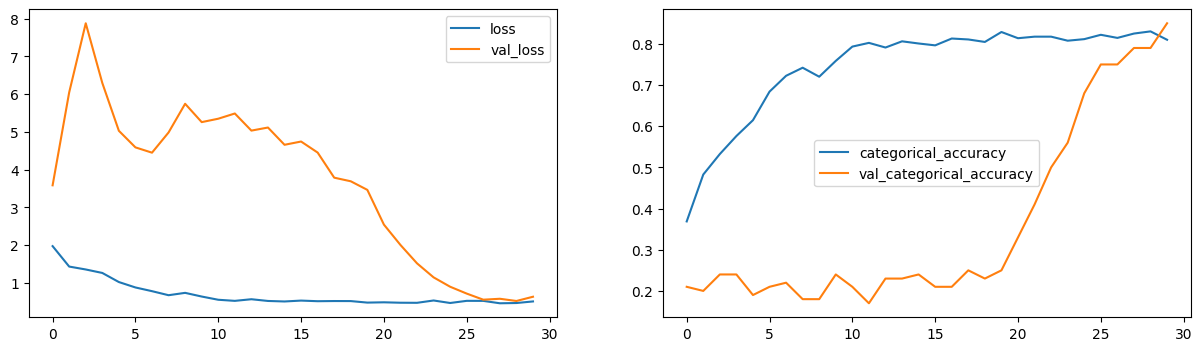

In [54]:
plot(history_model4)

Model has a best validation accuracy of 85% and training accuracy of 83% . Also we were able to reduce the parameter size by half the earlier model. Let's try adding dropouts at the convolution layers

# Model 5 Adding dropout at convolution layers

In [55]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [56]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=22)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_60 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_60 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_88 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_61 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_61 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_89 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                    

In [57]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/22
34/34 [==============================] - ETA: 0s - loss: 1.7472 - categorical_accuracy: 0.3673 
Epoch 1: saving model to model/model/model_init_2023-09-0308_46_04.877301\model-00001-1.74722-0.36727-2.03594-0.16000.h5
34/34 [==============================] - 989s 29s/step - loss: 1.7472 - categorical_accuracy: 0.3673 - val_loss: 2.0359 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/22
34/34 [==============================] - ETA: 0s - loss: 1.3378 - categorical_accuracy: 0.4985 
Epoch 2: saving model to model/model/model_init_2023-09-0308_46_04.877301\model-00002-1.33784-0.49849-2.87231-0.15000.h5
34/34 [==============================] - 986s 29s/step - loss: 1.3378 - categorical_accuracy: 0.4985 - val_loss: 2.8723 - val_categorical_accuracy: 0.1500 - lr: 0.0010
Epoch 3/22
34/34 [==============================] - ETA: 0s - loss: 1.0940 - categorical_accuracy: 0.5830 
Epoch 3: saving model to model/model/model_init_2023-09-0308_46_04.877301\model

34/34 [==============================] - 1000s 29s/step - loss: 0.3092 - categorical_accuracy: 0.8959 - val_loss: 4.3614 - val_categorical_accuracy: 0.2100 - lr: 1.6000e-06
Epoch 21/22
34/34 [==============================] - ETA: 0s - loss: 0.3014 - categorical_accuracy: 0.8952 
Epoch 21: saving model to model/model/model_init_2023-09-0308_46_04.877301\model-00021-0.30137-0.89517-3.97151-0.22000.h5

Epoch 21: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
34/34 [==============================] - 997s 29s/step - loss: 0.3014 - categorical_accuracy: 0.8952 - val_loss: 3.9715 - val_categorical_accuracy: 0.2200 - lr: 1.6000e-06
Epoch 22/22
34/34 [==============================] - ETA: 0s - loss: 0.3037 - categorical_accuracy: 0.8854 
Epoch 22: saving model to model/model/model_init_2023-09-0308_46_04.877301\model-00022-0.30373-0.88537-3.44437-0.22000.h5
34/34 [==============================] - 992s 29s/step - loss: 0.3037 - categorical_accuracy: 0.8854 - val_loss: 3.44

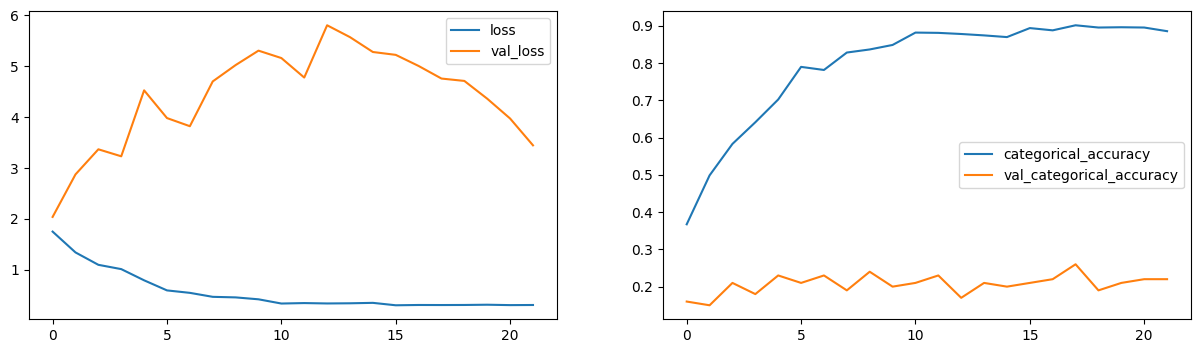

In [58]:
plot(history_model5)

Adding dropouts has further reduced validation accuracy a lot as its not to learn generalizable features
All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

# Model 6 - reducing the number of parameters

In [60]:
class ModelConv3D6(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [61]:
conv_3d6=ModelConv3D6()
conv_3d6.initialize_path(project_folder)
conv_3d6.initialize_image_properties(image_height=100,image_width=100)
conv_3d6.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d6_model=conv_3d6.define_model(dense_neurons=128,dropout=0.25)
conv_3d6_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_68 (Activation)  (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_98 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_60 (MaxPoolin  (None, 8, 50, 50, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_69 (Conv3D)          (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_69 (Activation)  (None, 8, 50, 50, 32)   

In [62]:
print("Total Params:", conv_3d6_model.count_params())
history_model6=conv_3d6.train_model(conv_3d6_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.6760 - categorical_accuracy: 0.3756
Epoch 1: saving model to model/model/model_init_2023-09-0314_55_54.439609\model-00001-1.67597-0.37557-1.86266-0.16000.h5
34/34 [==============================] - 212s 6s/step - loss: 1.6760 - categorical_accuracy: 0.3756 - val_loss: 1.8627 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2125 - categorical_accuracy: 0.5317
Epoch 2: saving model to model/model/model_init_2023-09-0314_55_54.439609\model-00002-1.21251-0.53167-2.55178-0.15000.h5
34/34 [==============================] - 214s 6s/step - loss: 1.2125 - categorical_accuracy: 0.5317 - val_loss: 2.5518 - val_categorical_accuracy: 0.1500 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.9484 - categorical_accuracy: 0.6207
Epoch 3: saving model to model/model/model_init_2023-09-0314_55_54.439609\mod

34/34 [==============================] - 210s 6s/step - loss: 0.5198 - categorical_accuracy: 0.8145 - val_loss: 3.3260 - val_categorical_accuracy: 0.2900 - lr: 3.2000e-07
Epoch 21/30
34/34 [==============================] - ETA: 0s - loss: 0.4934 - categorical_accuracy: 0.8183
Epoch 21: saving model to model/model/model_init_2023-09-0314_55_54.439609\model-00021-0.49340-0.81825-2.51639-0.34000.h5

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.399999961104187e-08.
34/34 [==============================] - 214s 6s/step - loss: 0.4934 - categorical_accuracy: 0.8183 - val_loss: 2.5164 - val_categorical_accuracy: 0.3400 - lr: 3.2000e-07
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.5030 - categorical_accuracy: 0.8167
Epoch 22: saving model to model/model/model_init_2023-09-0314_55_54.439609\model-00022-0.50305-0.81674-1.96049-0.35000.h5
34/34 [==============================] - 213s 6s/step - loss: 0.5030 - categorical_accuracy: 0.8167 - val_loss: 1.9605 - v

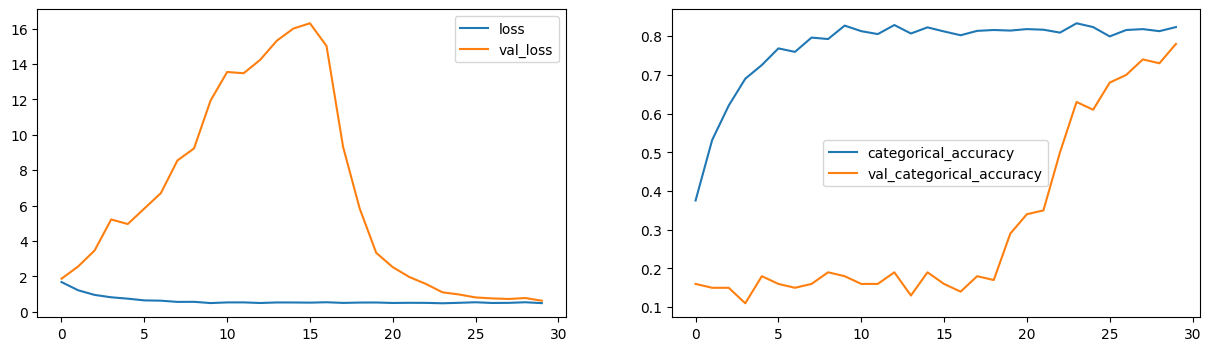

In [63]:
plot(history_model6)

For the above low memory model the best validation accuracy of 78% let try to reduce more parameters

# Model 7 - reducing the number of parameters

In [64]:
class ModelConv3D7(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [65]:
conv_3d7=ModelConv3D7()
conv_3d7.initialize_path(project_folder)
conv_3d7.initialize_image_properties(image_height=120,image_width=120)
conv_3d7.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d7_model=conv_3d7.define_model(dense_neurons=64,dropout=0.25)
conv_3d7_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_72 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_72 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_104 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_64 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_73 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_73 (Activation)  (None, 8, 60, 60, 32)   

In [66]:
print("Total Params:", conv_3d7_model.count_params())
history_model7=conv_3d7.train_model(conv_3d7_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7629 - categorical_accuracy: 0.3725 
Epoch 1: saving model to model/model/model_init_2023-09-0316_41_48.504489\model-00001-1.76287-0.37255-1.70797-0.18000.h5
34/34 [==============================] - 354s 10s/step - loss: 1.7629 - categorical_accuracy: 0.3725 - val_loss: 1.7080 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2379 - categorical_accuracy: 0.5166 
Epoch 2: saving model to model/model/model_init_2023-09-0316_41_48.504489\model-00002-1.23788-0.51659-1.72699-0.20000.h5
34/34 [==============================] - 353s 10s/step - loss: 1.2379 - categorical_accuracy: 0.5166 - val_loss: 1.7270 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.9616 - categorical_accuracy: 0.6350 
Epoch 3: saving model to model/model/model_init_2023-09-0316_41_48.50448

34/34 [==============================] - 355s 10s/step - loss: 0.4997 - categorical_accuracy: 0.8296 - val_loss: 3.0135 - val_categorical_accuracy: 0.2300 - lr: 3.2000e-07
Epoch 21/25
34/34 [==============================] - ETA: 0s - loss: 0.4877 - categorical_accuracy: 0.8424 
Epoch 21: saving model to model/model/model_init_2023-09-0316_41_48.504489\model-00021-0.48770-0.84238-2.43430-0.27000.h5

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.399999961104187e-08.
34/34 [==============================] - 357s 11s/step - loss: 0.4877 - categorical_accuracy: 0.8424 - val_loss: 2.4343 - val_categorical_accuracy: 0.2700 - lr: 3.2000e-07
Epoch 22/25
34/34 [==============================] - ETA: 0s - loss: 0.5012 - categorical_accuracy: 0.8220 
Epoch 22: saving model to model/model/model_init_2023-09-0316_41_48.504489\model-00022-0.50116-0.82202-1.92026-0.42000.h5
34/34 [==============================] - 353s 10s/step - loss: 0.5012 - categorical_accuracy: 0.8220 - val_loss: 1.920

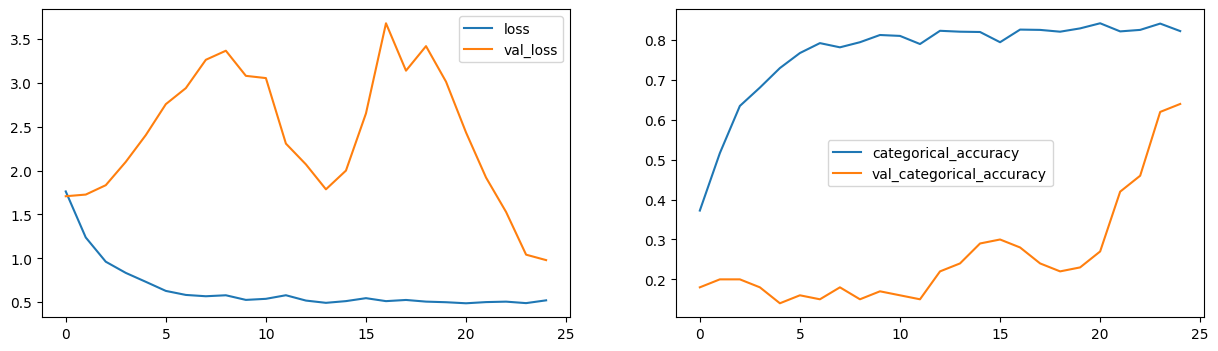

In [67]:
plot(history_model7)

For the above model the best validation accuracy of 64% which reduce after reducing parmeter
let try to reduce more parameters 

# Model 8 - reducing the number of parameters

In [68]:
class ModelConv3D8(ModelBuilder):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [69]:
conv_3d8=ModelConv3D8()
conv_3d8.initialize_path(project_folder)
conv_3d8.initialize_image_properties(image_height=120,image_width=120)
conv_3d8.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d8_model=conv_3d8.define_model(dense_neurons=64,dropout=0.25)
conv_3d8_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_76 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_76 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_110 (Ba  (None, 16, 120, 120, 8)  32        
 tchNormalization)                                               
                                                                 
 max_pooling3d_68 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_77 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_77 (Activation)  (None, 8, 60, 60, 16)   

In [70]:
print("Total Params:", conv_3d8_model.count_params())
history_model8=conv_3d8.train_model(conv_3d8_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9945 - categorical_accuracy: 0.2964
Epoch 1: saving model to model/model/model_init_2023-09-0319_09_26.940091\model-00001-1.99447-0.29638-1.76426-0.21000.h5
34/34 [==============================] - 215s 6s/step - loss: 1.9945 - categorical_accuracy: 0.2964 - val_loss: 1.7643 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.3874 - categorical_accuracy: 0.4487
Epoch 2: saving model to model/model/model_init_2023-09-0319_09_26.940091\model-00002-1.38742-0.44872-2.13701-0.19000.h5
34/34 [==============================] - 208s 6s/step - loss: 1.3874 - categorical_accuracy: 0.4487 - val_loss: 2.1370 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.1921 - categorical_accuracy: 0.5317
Epoch 3: saving model to model/model/model_init_2023-09-0319_09_26.940091\mod

34/34 [==============================] - 210s 6s/step - loss: 0.8283 - categorical_accuracy: 0.6795 - val_loss: 4.1079 - val_categorical_accuracy: 0.2300 - lr: 3.2000e-07
Epoch 21/30
34/34 [==============================] - ETA: 0s - loss: 0.8341 - categorical_accuracy: 0.6727
Epoch 21: saving model to model/model/model_init_2023-09-0319_09_26.940091\model-00021-0.83410-0.67270-3.13774-0.29000.h5

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.399999961104187e-08.
34/34 [==============================] - 208s 6s/step - loss: 0.8341 - categorical_accuracy: 0.6727 - val_loss: 3.1377 - val_categorical_accuracy: 0.2900 - lr: 3.2000e-07
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.8564 - categorical_accuracy: 0.6493
Epoch 22: saving model to model/model/model_init_2023-09-0319_09_26.940091\model-00022-0.85643-0.64932-2.42931-0.30000.h5
34/34 [==============================] - 206s 6s/step - loss: 0.8564 - categorical_accuracy: 0.6493 - val_loss: 2.4293 - v

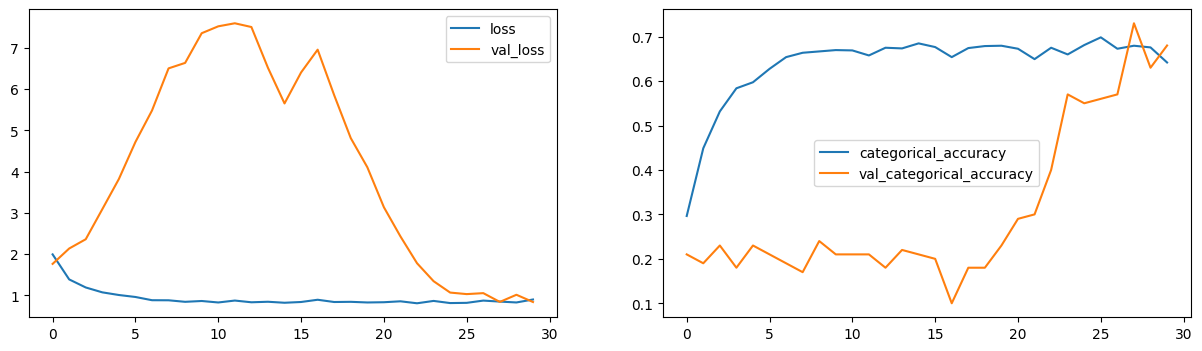

In [71]:
plot(history_model8)

For the above model the best validation accuracy of 68% which increase after reducing parmeter
let try to reduce more parameters 

# Model 9 - CNN- LSTM Model

In [79]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [80]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 18, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 18, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 18, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 60, 60, 32) 

In [81]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model9=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4585 - categorical_accuracy: 0.3756
Epoch 1: saving model to model/model/model_init_2023-09-0320_55_48.710971\model-00001-1.45847-0.37557-2.02518-0.21000.h5
34/34 [==============================] - 310s 9s/step - loss: 1.4585 - categorical_accuracy: 0.3756 - val_loss: 2.0252 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.1387 - categorical_accuracy: 0.5543
Epoch 2: saving model to model/model/model_init_2023-09-0320_55_48.710971\model-00002-1.13873-0.55430-1.78383-0.16000.h5
34/34 [==============================] - 253s 8s/step - loss: 1.1387 - categorical_accuracy: 0.5543 - val_loss: 1.7838 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.9163 - categorical_accuracy: 0.6456
Epoch 3: saving model to model/model/model_init_2023-09-0320_55_48.710971\model-0000

34/34 [==============================] - 254s 8s/step - loss: 0.1951 - categorical_accuracy: 0.9404 - val_loss: 1.9112 - val_categorical_accuracy: 0.4400 - lr: 1.6000e-06


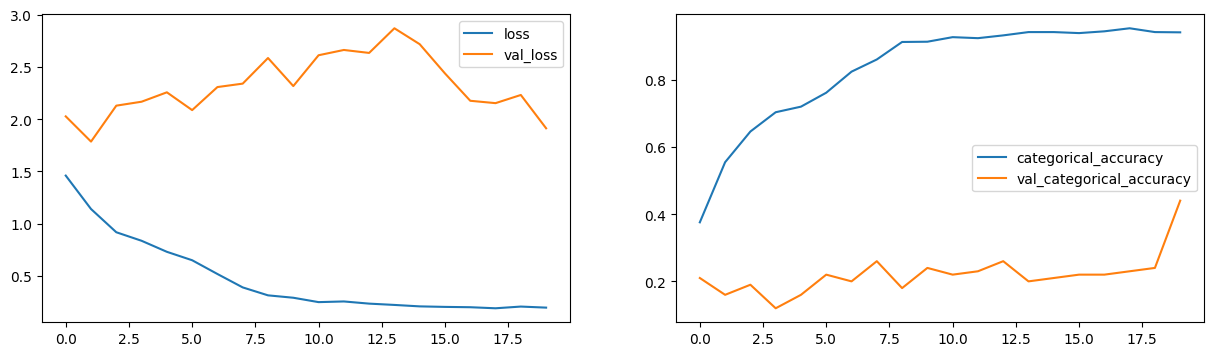

In [82]:
plot(history_model9)

For CNN - LSTM model we get a best validation accuracy of 44% may increase in number 
of epochs will result in higher accuracy

### As we see more cases of overfitting, lets augment the data with slight rotation as well and run the same set of models again

# More Augmentation

In [8]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model/model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = 'model/'+model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# Model 10 - (3,3,3) Filter & 160x160 Image resolution - similar to Model 2

In [92]:
class ModelConv3D10(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [93]:
conv_3d10=ModelConv3D10()
conv_3d10.initialize_path(project_folder)
conv_3d10.initialize_image_properties(image_height=160,image_width=160)
conv_3d10.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=30)
conv_3d10_model=conv_3d10.define_model(dense_neurons=256,dropout=0.5)
conv_3d10_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_88 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_88 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_138 (Ba  (None, 20, 160, 160, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_80 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_89 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                                 
 activation_89 (Activation)  (None, 10, 80, 80, 32)  

In [94]:
print("Total Params:", conv_3d10_model.count_params())
history_model10=conv_3d10.train_model(conv_3d10_model,augment_data=True)

Total Params: 3638981
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.1005 - categorical_accuracy: 0.3416 
Epoch 1: saving model to model/model/model_init_2023-09-0322_46_28.682149\model-00001-2.10048-0.34163-2.71747-0.21000.h5
34/34 [==============================] - 875s 26s/step - loss: 2.1005 - categorical_accuracy: 0.3416 - val_loss: 2.7175 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.4666 - categorical_accuracy: 0.5075 
Epoch 2: saving model to model/model/model_init_2023-09-0322_46_28.682149\model-00002-1.46664-0.50754-4.40350-0.23000.h5
34/34 [==============================] - 866s 25s/step - loss: 1.4666 - categorical_accuracy: 0.5075 - val_loss: 4.4035 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2496 - categorical_accuracy: 0.5603 
Epoch 3: saving model to model/model/model_init_2023-09-0322_46_28.6821

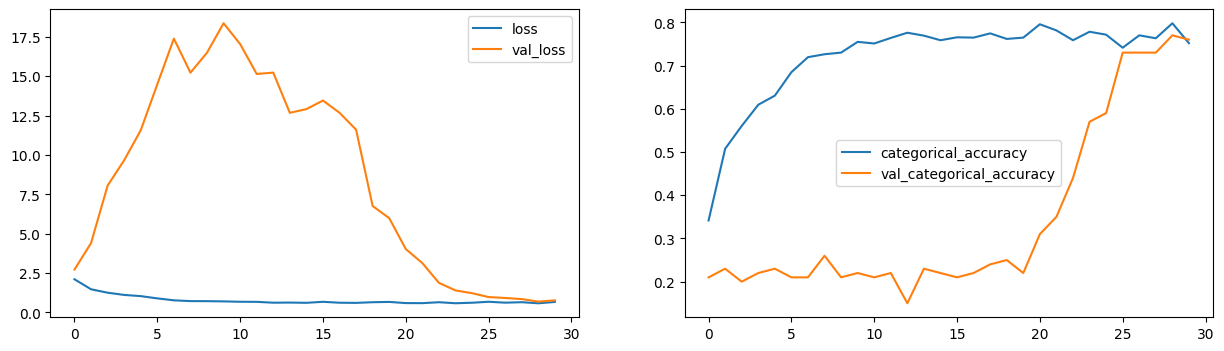

In [95]:
plot(history_model10)

# Model 11 - (2,2,2) Filter & 120x120 Image resolution - similar to Model 3

In [96]:
class ModelConv3D11(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [97]:
conv_3d11=ModelConv3D11()
conv_3d11.initialize_path(project_folder)
conv_3d11.initialize_image_properties(image_height=120,image_width=120)
conv_3d11.initialize_hyperparams(frames_to_sample=16,batch_size=30,num_epochs=30)
conv_3d11_model=conv_3d11.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d11_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_92 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_92 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_144 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 max_pooling3d_84 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_93 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_93 (Activation)  (None, 8, 60, 60, 32)   

In [98]:
print("Total Params:", conv_3d11_model.count_params())
history_model11=conv_3d11.train_model(conv_3d11_model,augment_data=True)

Total Params: 1762613
Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 2.1221 - categorical_accuracy: 0.3326 
Epoch 1: saving model to model/model/model_init_2023-09-0405_40_59.633779\model-00001-2.12211-0.33258-1.81270-0.16000.h5
23/23 [==============================] - 274s 12s/step - loss: 2.1221 - categorical_accuracy: 0.3326 - val_loss: 1.8127 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 1.5158 - categorical_accuracy: 0.4955 
Epoch 2: saving model to model/model/model_init_2023-09-0405_40_59.633779\model-00002-1.51578-0.49548-2.34043-0.19000.h5
23/23 [==============================] - 262s 11s/step - loss: 1.5158 - categorical_accuracy: 0.4955 - val_loss: 2.3404 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 1.3475 - categorical_accuracy: 0.5362 
Epoch 3: saving model to model/model/model_init_2023-09-0405_40_59.6337

23/23 [==============================] - 260s 11s/step - loss: 0.8315 - categorical_accuracy: 0.7014 - val_loss: 9.1497 - val_categorical_accuracy: 0.1600 - lr: 3.2000e-07
Epoch 21/30
23/23 [==============================] - ETA: 0s - loss: 0.8587 - categorical_accuracy: 0.7014 
Epoch 21: saving model to model/model/model_init_2023-09-0405_40_59.633779\model-00021-0.85871-0.70136-8.71589-0.16000.h5

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.399999961104187e-08.
23/23 [==============================] - 262s 11s/step - loss: 0.8587 - categorical_accuracy: 0.7014 - val_loss: 8.7159 - val_categorical_accuracy: 0.1600 - lr: 3.2000e-07
Epoch 22/30
23/23 [==============================] - ETA: 0s - loss: 0.8860 - categorical_accuracy: 0.6923 
Epoch 22: saving model to model/model/model_init_2023-09-0405_40_59.633779\model-00022-0.88601-0.69231-8.03430-0.17000.h5
23/23 [==============================] - 262s 11s/step - loss: 0.8860 - categorical_accuracy: 0.6923 - val_loss: 8.034

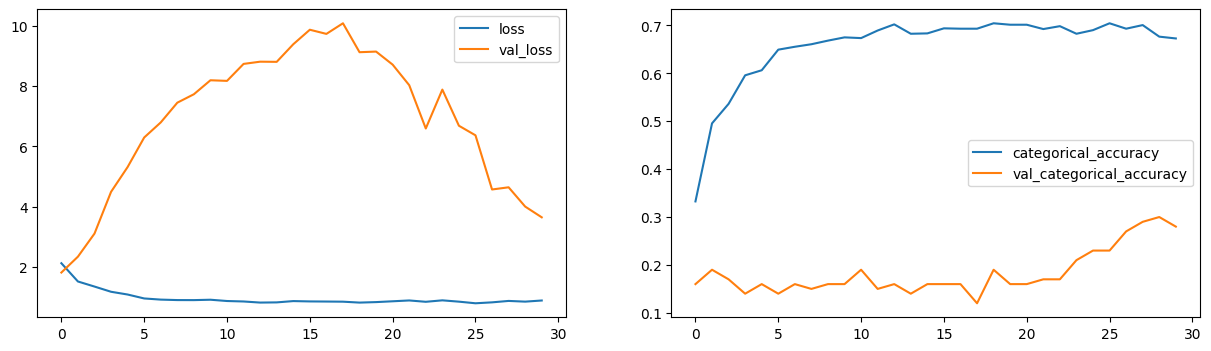

In [99]:
plot(history_model11)

# Model 12 - Adding more layers - Similar to model 4

In [100]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [101]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.5)
conv_3d12_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_96 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_96 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_150 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                               
                                                                 
 conv3d_97 (Conv3D)          (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_97 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_151 (Ba  (None, 16, 120, 120, 16)  64       
 tchNormalization)                                   

In [102]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.1068 - categorical_accuracy: 0.3492 
Epoch 1: saving model to model/model/model_init_2023-09-0407_52_19.842064\model-00001-2.10676-0.34917-2.19839-0.21000.h5
34/34 [==============================] - 971s 28s/step - loss: 2.1068 - categorical_accuracy: 0.3492 - val_loss: 2.1984 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5887 - categorical_accuracy: 0.4706 
Epoch 2: saving model to model/model/model_init_2023-09-0407_52_19.842064\model-00002-1.58869-0.47059-3.82640-0.20000.h5
34/34 [==============================] - 966s 28s/step - loss: 1.5887 - categorical_accuracy: 0.4706 - val_loss: 3.8264 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.3424 - categorical_accuracy: 0.5483 
Epoch 3: saving model to model/model/model_init_2023-09-0407_52_19.8420

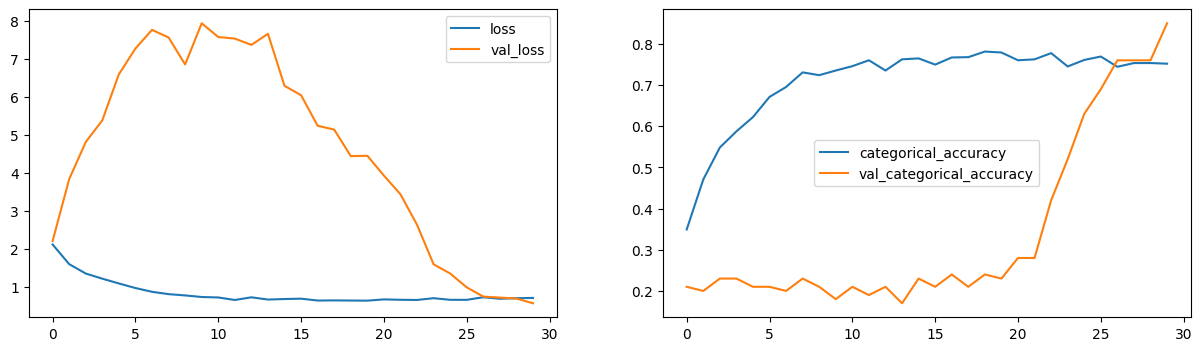

In [103]:
plot(history_model12)

# Model 13 - Adding dropouts - Similar to Model 5

In [9]:
class ModelConv3D13(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d13=ModelConv3D13()
conv_3d13.initialize_path(project_folder)
conv_3d13.initialize_image_properties(image_height=120,image_width=120)
conv_3d13.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d13_model=conv_3d13.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d13_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 16, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 16, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 120, 120, 16)  64       
 hNormalization)                                        

In [11]:
print("Total Params:", conv_3d13_model.count_params())
history_model13=conv_3d13.train_model(conv_3d13_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 2.0110 - categorical_accuracy: 0.2986 
Epoch 1: saving model to model/model/model_init_2023-09-0417_00_52.307929\model-00001-2.01104-0.29864-2.01881-0.21000.h5
34/34 [==============================] - 1062s 31s/step - loss: 2.0110 - categorical_accuracy: 0.2986 - val_loss: 2.0188 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.6229 - categorical_accuracy: 0.4140 
Epoch 2: saving model to model/model/model_init_2023-09-0417_00_52.307929\model-00002-1.62287-0.41403-2.73956-0.22000.h5
34/34 [==============================] - 1030s 30s/step - loss: 1.6229 - categorical_accuracy: 0.4140 - val_loss: 2.7396 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.4168 - categorical_accuracy: 0.4721 
Epoch 3: saving model to model/model/model_init_2023-09-0417_00_52.30

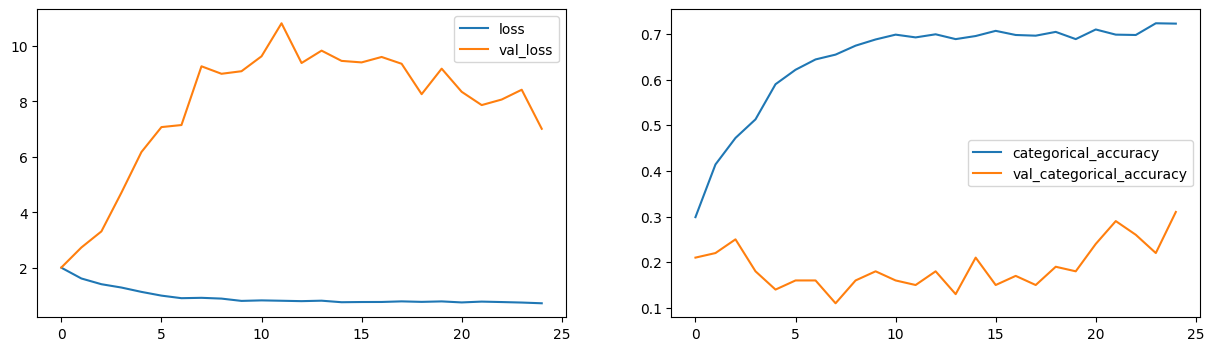

In [63]:
plot(history_model13)

# Model 14 - reducing network parameters - Similar to Model 6

In [12]:
class ModelConv3D14(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model


In [13]:
conv_3d14=ModelConv3D14()
conv_3d14.initialize_path(project_folder)
conv_3d14.initialize_image_properties(image_height=100,image_width=100)
conv_3d14.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d14_model=conv_3d14.define_model(dense_neurons=128,dropout=0.25)
conv_3d14_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 16, 100, 100, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 16, 100, 100, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 16, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 8, 50, 50, 16)    0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 8, 50, 50, 32)     4128      
                                                                 
 activation_9 (Activation)   (None, 8, 50, 50, 32)    

In [14]:
print("Total Params:", conv_3d14_model.count_params())
history_model14=conv_3d14.train_model(conv_3d14_model,augment_data=True)

Total Params: 696645
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.8013 - categorical_accuracy: 0.3296
Epoch 1: saving model to model/model/model_init_2023-09-0500_03_18.781598\model-00001-1.80131-0.32956-1.70932-0.21000.h5
34/34 [==============================] - 211s 6s/step - loss: 1.8013 - categorical_accuracy: 0.3296 - val_loss: 1.7093 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.1282 - categorical_accuracy: 0.5754
Epoch 2: saving model to model/model/model_init_2023-09-0500_03_18.781598\model-00002-1.12817-0.57541-2.00737-0.22000.h5
34/34 [==============================] - 210s 6s/step - loss: 1.1282 - categorical_accuracy: 0.5754 - val_loss: 2.0074 - val_categorical_accuracy: 0.2200 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 0.9443 - categorical_accuracy: 0.6365
Epoch 3: saving model to model/model/model_init_2023-09-0500_03_18.781598\mod

34/34 [==============================] - 206s 6s/step - loss: 0.5492 - categorical_accuracy: 0.8002 - val_loss: 4.8505 - val_categorical_accuracy: 0.2500 - lr: 3.2000e-07
Epoch 21/30
34/34 [==============================] - ETA: 0s - loss: 0.5691 - categorical_accuracy: 0.7971
Epoch 21: saving model to model/model/model_init_2023-09-0500_03_18.781598\model-00021-0.56914-0.79713-3.06183-0.27000.h5

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.399999961104187e-08.
34/34 [==============================] - 206s 6s/step - loss: 0.5691 - categorical_accuracy: 0.7971 - val_loss: 3.0618 - val_categorical_accuracy: 0.2700 - lr: 3.2000e-07
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.5550 - categorical_accuracy: 0.8002
Epoch 22: saving model to model/model/model_init_2023-09-0500_03_18.781598\model-00022-0.55495-0.80015-2.21296-0.33000.h5
34/34 [==============================] - 206s 6s/step - loss: 0.5550 - categorical_accuracy: 0.8002 - val_loss: 2.2130 - v

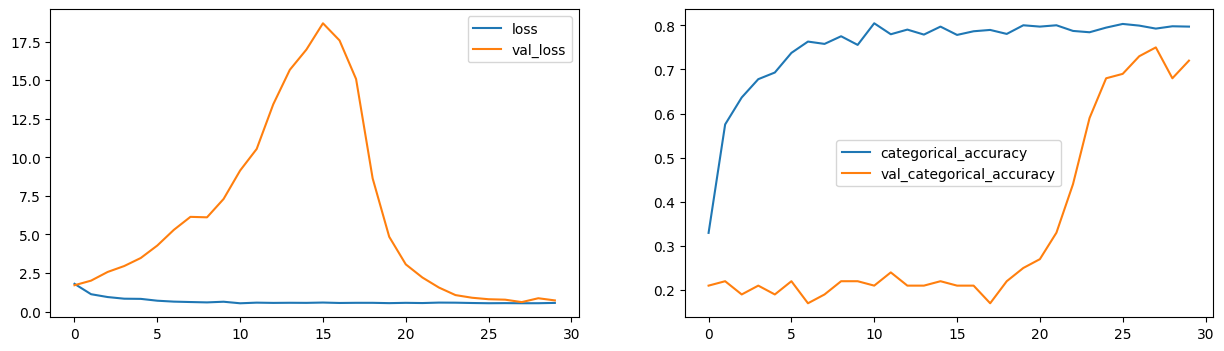

In [15]:
plot(history_model14)

# Model 15 - reducing network parameters - Similar to model 7

In [16]:
class ModelConv3D15(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [17]:
conv_3d15=ModelConv3D15()
conv_3d15.initialize_path(project_folder)
conv_3d15.initialize_image_properties(image_height=120,image_width=120)
conv_3d15.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d15_model=conv_3d15.define_model(dense_neurons=64,dropout=0.25)
conv_3d15_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 16, 120, 120, 16)  1312      
                                                                 
 activation_12 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 batch_normalization_16 (Bat  (None, 16, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 8, 60, 60, 16)    0         
 3D)                                                             
                                                                 
 conv3d_13 (Conv3D)          (None, 8, 60, 60, 32)     13856     
                                                                 
 activation_13 (Activation)  (None, 8, 60, 60, 32)    

In [18]:
print("Total Params:", conv_3d15_model.count_params())
history_model15=conv_3d15.train_model(conv_3d15_model,augment_data=True)

Total Params: 504709
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.8387 - categorical_accuracy: 0.3258 
Epoch 1: saving model to model/model/model_init_2023-09-0501_46_52.549294\model-00001-1.83868-0.32579-1.85500-0.16000.h5
34/34 [==============================] - 349s 10s/step - loss: 1.8387 - categorical_accuracy: 0.3258 - val_loss: 1.8550 - val_categorical_accuracy: 0.1600 - lr: 2.0000e-04
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3008 - categorical_accuracy: 0.5015 
Epoch 2: saving model to model/model/model_init_2023-09-0501_46_52.549294\model-00002-1.30083-0.50151-2.44492-0.18000.h5
34/34 [==============================] - 346s 10s/step - loss: 1.3008 - categorical_accuracy: 0.5015 - val_loss: 2.4449 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 1.1032 - categorical_accuracy: 0.5837
Epoch 3: saving model to model/model/model_init_2023-09-0501_46_52.549294

34/34 [==============================] - 340s 10s/step - loss: 0.6187 - categorical_accuracy: 0.7640 - val_loss: 4.0578 - val_categorical_accuracy: 0.2500 - lr: 3.2000e-07
Epoch 21/25
34/34 [==============================] - ETA: 0s - loss: 0.6306 - categorical_accuracy: 0.7632 
Epoch 21: saving model to model/model/model_init_2023-09-0501_46_52.549294\model-00021-0.63056-0.76320-2.65264-0.30000.h5

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.399999961104187e-08.
34/34 [==============================] - 344s 10s/step - loss: 0.6306 - categorical_accuracy: 0.7632 - val_loss: 2.6526 - val_categorical_accuracy: 0.3000 - lr: 3.2000e-07
Epoch 22/25
34/34 [==============================] - ETA: 0s - loss: 0.6367 - categorical_accuracy: 0.7640
Epoch 22: saving model to model/model/model_init_2023-09-0501_46_52.549294\model-00022-0.63670-0.76395-1.93267-0.39000.h5
34/34 [==============================] - 341s 10s/step - loss: 0.6367 - categorical_accuracy: 0.7640 - val_loss: 1.9327

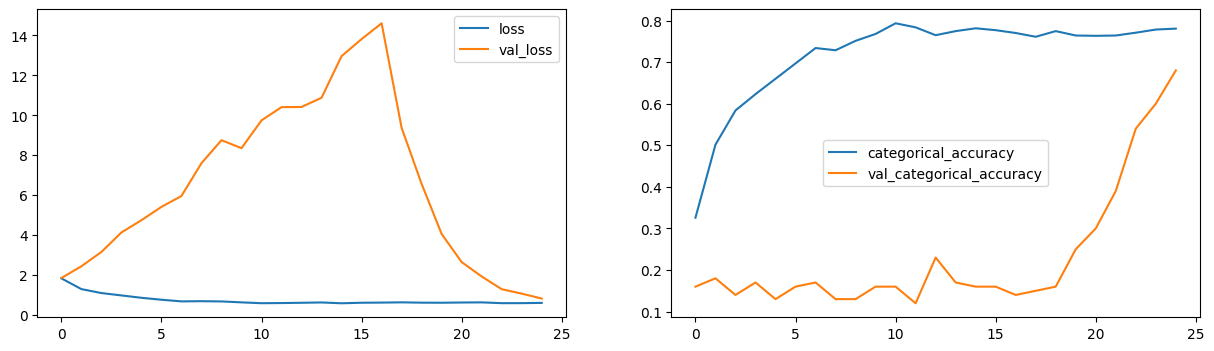

In [19]:
plot(history_model15)

# Model 16 - reducing network parameters - Similar to Model 8

In [20]:
class ModelConv3D16(ModelBuilderMoreAugmentation):
    
    def define_model(self,dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(8, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(16, (3, 3, 3), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [21]:
conv_3d16=ModelConv3D16()
conv_3d16.initialize_path(project_folder)
conv_3d16.initialize_image_properties(image_height=120,image_width=120)
conv_3d16.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=30)
conv_3d16_model=conv_3d16.define_model(dense_neurons=64,dropout=0.25)
conv_3d16_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 16, 120, 120, 8)   656       
                                                                 
 activation_16 (Activation)  (None, 16, 120, 120, 8)   0         
                                                                 
 batch_normalization_22 (Bat  (None, 16, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 8, 60, 60, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 8, 60, 60, 16)     3472      
                                                                 
 activation_17 (Activation)  (None, 8, 60, 60, 16)    

In [22]:
print("Total Params:", conv_3d16_model.count_params())
history_model16=conv_3d16.train_model(conv_3d16_model,augment_data=True)

Total Params: 230949
Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 1.9096 - categorical_accuracy: 0.3220
Epoch 1: saving model to model/model/model_init_2023-09-0504_09_31.579589\model-00001-1.90959-0.32202-1.63304-0.21000.h5
34/34 [==============================] - 202s 6s/step - loss: 1.9096 - categorical_accuracy: 0.3220 - val_loss: 1.6330 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.3698 - categorical_accuracy: 0.4698
Epoch 2: saving model to model/model/model_init_2023-09-0504_09_31.579589\model-00002-1.36979-0.46983-1.79984-0.12000.h5
34/34 [==============================] - 197s 6s/step - loss: 1.3698 - categorical_accuracy: 0.4698 - val_loss: 1.7998 - val_categorical_accuracy: 0.1200 - lr: 2.0000e-04
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 1.2292 - categorical_accuracy: 0.5121
Epoch 3: saving model to model/model/model_init_2023-09-0504_09_31.579589\mod

34/34 [==============================] - 197s 6s/step - loss: 0.7846 - categorical_accuracy: 0.7021 - val_loss: 2.7608 - val_categorical_accuracy: 0.2300 - lr: 3.2000e-07
Epoch 21/30
34/34 [==============================] - ETA: 0s - loss: 0.8031 - categorical_accuracy: 0.7044
Epoch 21: saving model to model/model/model_init_2023-09-0504_09_31.579589\model-00021-0.80310-0.70437-2.17418-0.28000.h5

Epoch 21: ReduceLROnPlateau reducing learning rate to 6.399999961104187e-08.
34/34 [==============================] - 196s 6s/step - loss: 0.8031 - categorical_accuracy: 0.7044 - val_loss: 2.1742 - val_categorical_accuracy: 0.2800 - lr: 3.2000e-07
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.8104 - categorical_accuracy: 0.6923
Epoch 22: saving model to model/model/model_init_2023-09-0504_09_31.579589\model-00022-0.81040-0.69231-1.77705-0.31000.h5
34/34 [==============================] - 194s 6s/step - loss: 0.8104 - categorical_accuracy: 0.6923 - val_loss: 1.7771 - v

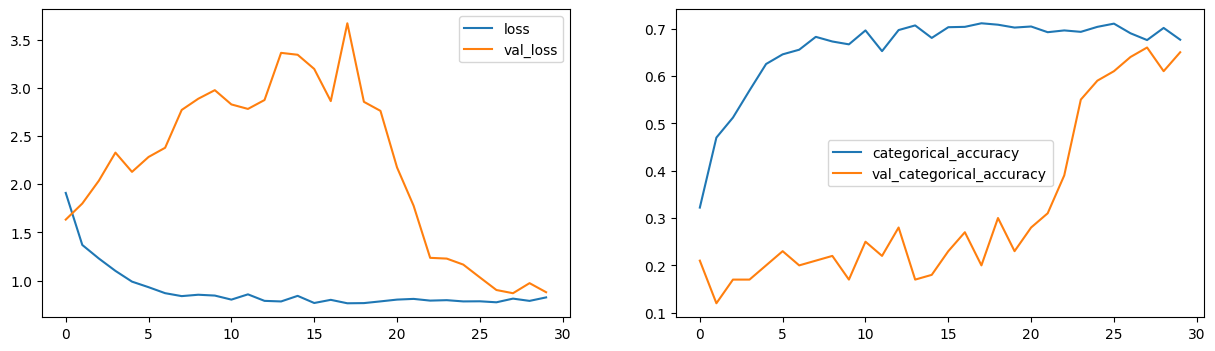

In [23]:
plot(history_model16)

# Model 17 - CNN LSTM with GRU - Similar to Model 9

In [24]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [25]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 60, 60, 32)  

In [26]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model17=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - ETA: 0s - loss: 1.4805 - categorical_accuracy: 0.3906
Epoch 1: saving model to model/model/model_init_2023-09-0505_47_29.094980\model-00001-1.48045-0.39065-1.85880-0.21000.h5
34/34 [==============================] - 286s 8s/step - loss: 1.4805 - categorical_accuracy: 0.3906 - val_loss: 1.8588 - val_categorical_accuracy: 0.2100 - lr: 2.0000e-04
Epoch 2/20
34/34 [==============================] - ETA: 0s - loss: 1.0491 - categorical_accuracy: 0.5935
Epoch 2: saving model to model/model/model_init_2023-09-0505_47_29.094980\model-00002-1.04914-0.59351-2.52144-0.20000.h5
34/34 [==============================] - 249s 7s/step - loss: 1.0491 - categorical_accuracy: 0.5935 - val_loss: 2.5214 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/20
34/34 [==============================] - ETA: 0s - loss: 0.8362 - categorical_accuracy: 0.6848
Epoch 3: saving model to model/model/model_init_2023-09-0505_47_29.094980\mo

34/34 [==============================] - 234s 7s/step - loss: 0.2836 - categorical_accuracy: 0.9238 - val_loss: 2.3570 - val_categorical_accuracy: 0.2600 - lr: 3.2000e-07


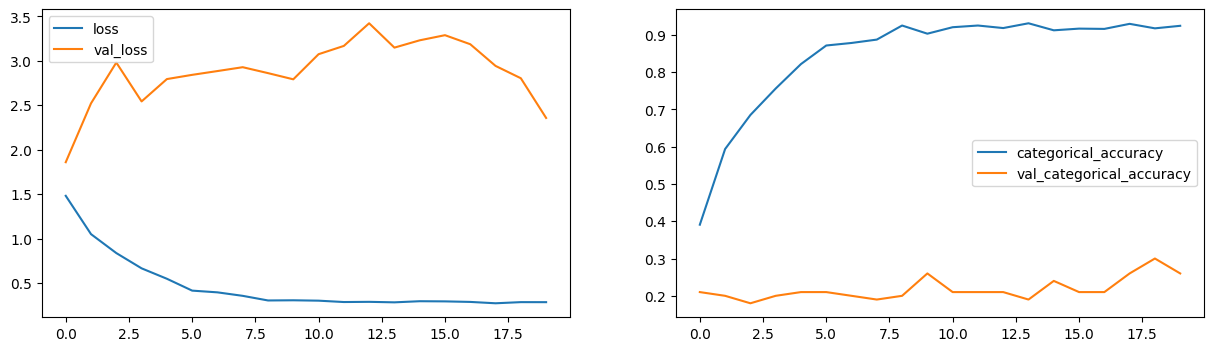

In [27]:
plot(history_model17)

### We see that overfitting is considerably less when we do more augmentation. However there is not much improvement on accuracy

# Model 18 - Transfer Learning

In [28]:
from keras.applications import mobilenet

In [59]:
class RNNCNN_TL(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):
        
        mobilenet_transfer = mobilenet.MobileNet(input_shape=(self.image_height,self.image_width,self.channels) ,weights='imagenet', include_top=False)

        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        
        for layer in model.layers:
            layer.trainable = False
        
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [60]:
rnn_cnn_tl=RNNCNN_TL()
rnn_cnn_tl.initialize_path(project_folder)
rnn_cnn_tl.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl_model=rnn_cnn_tl.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_30 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_31 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_32 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 128)             

In [61]:
print("Total Params:", rnn_cnn_tl_model.count_params())
history_model18=rnn_cnn_tl.train_model(rnn_cnn_tl_model,augment_data=True)

Total Params: 3840453
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 1.6424 - categorical_accuracy: 0.2006
Epoch 1: saving model to model/model/model_init_2023-09-0511_02_13.178932\model-00001-1.64236-0.20060-1.60830-0.23000.h5
133/133 [==============================] - 225s 2s/step - loss: 1.6424 - categorical_accuracy: 0.2006 - val_loss: 1.6083 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 1.5811 - categorical_accuracy: 0.2670
Epoch 2: saving model to model/model/model_init_2023-09-0511_02_13.178932\model-00002-1.58105-0.26697-1.59516-0.30000.h5
133/133 [==============================] - 164s 1s/step - loss: 1.5811 - categorical_accuracy: 0.2670 - val_loss: 1.5952 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 1.5726 - categorical_accuracy: 0.2670
Epoch 3: saving model to model/model/model_init_2023-09-0511_02_13.178932\

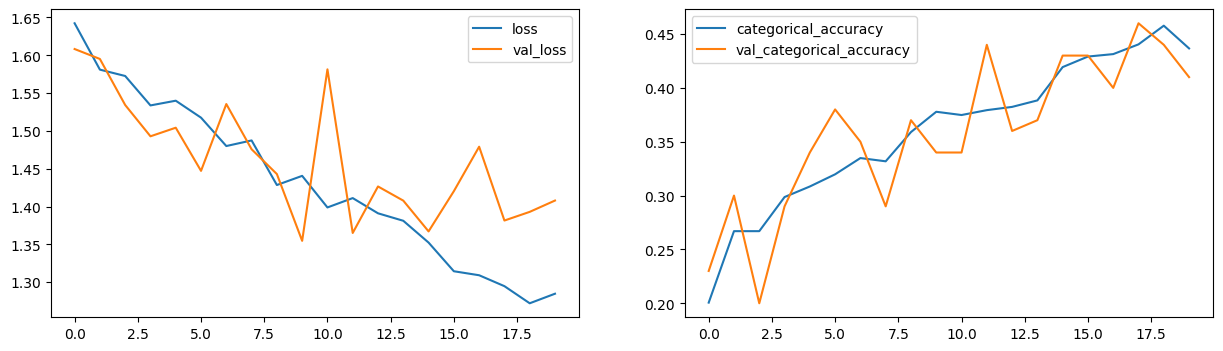

In [62]:
plot(history_model18)

We are not training the mobilenet weights and we see validation accuracy is very poor. Let's train them as well and observe if there is performance improvement

# Model 19 - Transfer Learning with GRU and training all weights

In [64]:
class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        mobilenet_transfer = mobilenet.MobileNet(input_shape=(self.image_height,self.image_width,self.channels) ,weights='imagenet', include_top=False)
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [65]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_33 (TimeDi  (None, 16, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_34 (TimeDi  (None, 16, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_35 (TimeDi  (None, 16, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_36 (TimeDi  (None, 16, 1024)         0         
 stributed)                                                      
                                                                 
 gru_2 (GRU)                 (None, 128)             

In [66]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model19=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - ETA: 0s - loss: 0.9782 - categorical_accuracy: 0.6433
Epoch 1: saving model to model/model/model_init_2023-09-0511_58_22.313821\model-00001-0.97822-0.64329-2.13643-0.18000.h5
133/133 [==============================] - 532s 4s/step - loss: 0.9782 - categorical_accuracy: 0.6433 - val_loss: 2.1364 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.3817 - categorical_accuracy: 0.8786
Epoch 2: saving model to model/model/model_init_2023-09-0511_58_22.313821\model-00002-0.38172-0.87858-1.26097-0.54000.h5
133/133 [==============================] - 516s 4s/step - loss: 0.3817 - categorical_accuracy: 0.8786 - val_loss: 1.2610 - val_categorical_accuracy: 0.5400 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.2923 - categorical_accuracy: 0.9057
Epoch 3: saving model to model/model/model_init_2023-09-0511_58_22.313821\

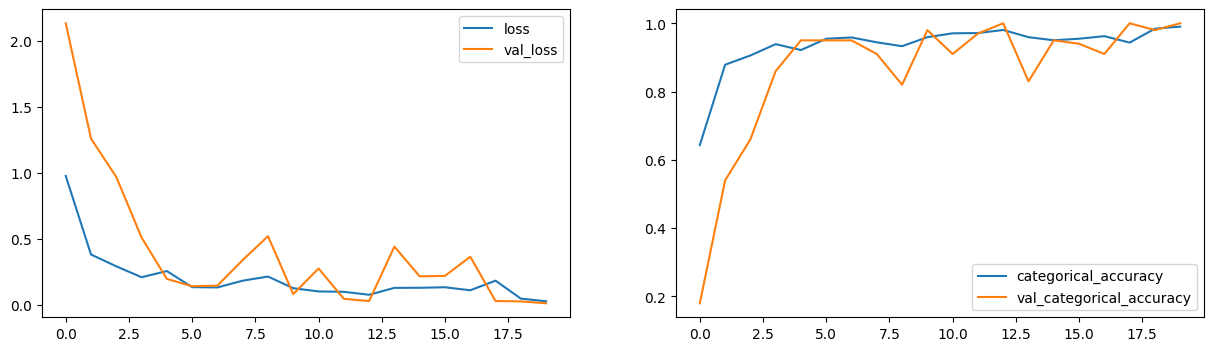

In [67]:
plot(history_model19)

we can see that the model validation accuracy has increased significantly around 100% and training accuracy at 99%.
training all the mobilenet weights help in improve the model performance significantly.

# Loading model and Testing

In [68]:
import time
from keras.models import load_model

In [71]:
model = load_model('model\\model\\model_init_2023-09-0511_58_22.313821\\model-00020-0.02675-0.99020-0.01176-1.00000.h5')

In [77]:
test_generator=RNNCNN_TL2()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [78]:
batch_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [79]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

1/1 [==============================] - 2s 2s/step
[1 3 2 0 2]
